# Hidden markov model (HMM)

We show how contact duration, passage time and frequencies depend on the distance between ctcf sites. We consider only the best set of parameters in the presence of extruders and barriers. We calculate the model for 150kb and apply it to all other setups.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hmmlearn import hmm
from matplotlib.backends.backend_pdf import PdfPages
from utils import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import glob
import pathlib
import gdown
import os
import zipfile
import matplotlib
import matplotlib.colors as mcolors

matplotlib.rcParams["pdf.fonttype"] = 42

In [3]:
reproducible = True
distance_conversion = 0.012 * np.sqrt(40)  # 1 a.u. = 0.08 um
rolling = 1
if reproducible:
    seed = 42
    np.random.seed(seed)
subsample = False

if subsample:
    number_subsample = 200000

# Reading simulated data

In [4]:
dataset_name = "tad_sizes"
basedir = f"./{dataset_name}/"
# create a folder
pathlib.Path(basedir).mkdir(parents=True, exist_ok=True)
# basedir = "/tungstenfs/scratch/ggiorget/pavel/code_projects/systematic_chrodyn_simulations/langevin_simulations/analysis_sweep/revision1/diff_tads/"
sample_link = (
    "https://drive.google.com/uc?export=download&id=1hnxHHv08_yVkWxMPXyt6PCeJpxja75p9"
)
# download data if not already present
if not os.path.isfile(basedir + f"{dataset_name}.zip"):
    gdown.download(sample_link, basedir + f"{dataset_name}.zip")
# unzip the data
with zipfile.ZipFile(basedir + f"{dataset_name}.zip", "r") as zip_ref:
    zip_ref.extractall(basedir)
list_files = glob.glob(f"{basedir}/diff_tads_data/*/*/*/*/*/*/dst_bnd.dat")

filenames = pd.DataFrame(list_files, columns=["filename"])
filenames[["tad_size", "ctcf", "speed", "loading", "unloading", "rep"]] = filenames[
    "filename"
].str.extract(
    r"diff_tads_data\/([\d+]*)\/([\w+]*)\/([\d+]*)\/([\d]\.[\d+]*)\/([\d]\.[\d+]*)\/([\d+]*)\/",
    expand=True,
)
conversion_kb_to_beads = {
    "100": "12",
    "150": "18",
    "250": "29",
    "500": "61",
    "1000": "123",
}
conversion_beads_to_kb = {"12": 100, "18": 150, "29": 250, "61": 500, "123": 1000}
conversion_beads_to_kb_int = {int(k): int(v) for k, v in conversion_beads_to_kb.items()}
filenames = filenames.replace({"tad_size": conversion_kb_to_beads})

filenames["condition"] = (
    filenames["tad_size"]
    + "_"
    + filenames["speed"]
    + "."
    + filenames["loading"]
    + "_"
    + filenames["unloading"]
)
filenames["uniqueid"] = (
    filenames["tad_size"]
    + "_"
    + "ctcf"
    + filenames["ctcf"]
    + "."
    + "rad21"
    + "on"
    + "_"
    + filenames["speed"]
    + "."
    + filenames["loading"]
    + "."
    + filenames["unloading"]
    + "."
    + filenames["rep"]
)

In [5]:
all_tad_sizes_dataset_orig = []
for tad_size, sub3 in filenames.groupby("tad_size"):
    alldf = []
    for condition, sub2 in sub3.groupby("condition"):
        for uniqueid, sub1 in sub2.groupby("uniqueid"):
            for ct, sub in sub1.groupby("ctcf"):
                for file in sub.filename.unique():
                    tmp = pd.read_csv(file, sep=" ")
                    tmp.distance = tmp.distance * distance_conversion
                    try:
                        tmp.drop(
                            ["x1", "y1", "z1", "x2", "y2", "z2"], axis=1, inplace=True
                        )
                    except:
                        pass
                    tmp["tad_size"] = tad_size
                    tmp["condition"] = condition
                    tmp["frame"] = np.arange(len(tmp))
                    tmp["uniqueid"] = uniqueid
                    tmp["ctcf"] = ct
                    tmp["rad21"] = "on"
                    if subsample:
                        tmp = tmp.head(number_subsample)
                    #                 distances_original = pd.concat([distances_original, tmp])
                    alldf.append(tmp)
    distances_original = pd.concat(alldf)
    all_tad_sizes_dataset_orig.append(distances_original)

# Subsampling  to 30s and training 2 state hmm

In [6]:
# choose neighbors
nneighbor = 2
subsample_every = 30
all_tad_sizes_dataset = []
idx = []
for distances in all_tad_sizes_dataset_orig:
    tad_size = int(distances.tad_size.unique()[0])
    idx = (
        np.where(
            np.array([abs(eval(x)) for x in distances.columns[1:][:-7]])
            >= tad_size - nneighbor
        )[0]
        + 1
    )
    distances["bond"] = distances.iloc[:, idx].sum(axis=1)
    distances.loc[distances["bond"] > 1, "bond"] = 1

    distances = distances.iloc[::subsample_every].copy()
    distances.bond = 1 - distances.bond.values
    distances_nonoise = distances.copy()
    # add experimental noise
    seed = 0
    np.random.seed(seed)
    distances.distance = distances.distance.values + np.random.normal(
        loc=0.0, scale=0.064, size=len(distances)
    )
    distances.frame = distances.frame.values / subsample_every
    all_tad_sizes_dataset.append(distances)

In [7]:
# run HMM training on all conditions
results = {}
np.random.seed(seed)
for distances in all_tad_sizes_dataset:
    for condition, sub in distances.groupby("condition"):
        traj2d = np.reshape(
            sub[sub.ctcf == "on"].distance.to_numpy(),
            (-1, 1),
        )
        #        model = hmm.GaussianHMM(
        #            n_components=2,
        #            covariance_type="full",
        #            min_covar=0.1,
        #            n_iter=10000,
        #            params="mtc",
        #            init_params="mtc",
        #            hack=True,
        #            hack_mean=0.15507389,
        #            hack_covar=0.00775845,
        #        )
        # print(model.covariance_type)
        model = hmm.GaussianHMM(
            n_components=2,
            covariance_type="full",
            min_covar=0.1,
            n_iter=10000,
            params="t",
            init_params="t",
        )
        model.means_ = [[0.17922608], [0.43435689]]  # 18 beads
        # [[0.15507389], [0.39257526]] # 12 beads

        model.covars_ = [[[0.00921505]], [[0.01828777]]]  # 18 beads
        # [[[0.00775845]], [[0.01408439]]] # 12 beads

        # instead of fitting
        model.startprob_ = [0.5, 0.5]
        model.fit(traj2d)

        results[condition] = model
models2hmm = results.copy()

In [8]:
# reorder HMM model such that the first gaussian is always the lowest
for key, model in results.items():
    newmodel = reorder_hmm_model_parameters(model)
    model = newmodel
    means = model.means_
    sigmas = np.sqrt(model.covars_.squeeze())
    w = np.array(model.transmat_)
    logProb = model.score(traj2d)
    print(f"tad-ctcf-speed-loading-unloading = {key}")
    print(f"Gaussian means: {means}")
    print(f"Gaussian std: {sigmas}")
    print(f"Gaussian covars_ {model.covars_}")
    print(f"Transition rates: {w}")
    print("----------\n")

tad-ctcf-speed-loading-unloading = 12_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.01828777]]]
Transition rates: [[0.96219416 0.03780584]
 [0.06083393 0.93916607]]
----------

tad-ctcf-speed-loading-unloading = 123_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.01828777]]]
Transition rates: [[7.07232977e-01 2.92767023e-01]
 [2.19453991e-09 9.99999998e-01]]
----------

tad-ctcf-speed-loading-unloading = 18_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.01828777]]]
Transition rates: [[0.96122776 0.03877224]
 [0.04823642 0.95176358]]
----------

tad-ctcf-speed-loading-unloading = 29_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.

# Reading experimental data

In [9]:
dataset = "211221_two_colors_distance_30s.csv"
basedir = f"./{dataset}/"
# create a folder
pathlib.Path(basedir).mkdir(parents=True, exist_ok=True)
sample_link = (
    "https://drive.google.com/uc?export=download&id=1szF0P4OcA0X8WoPha5CKjo0sCLhJnrtX"
)
if not os.path.isfile(f"{basedir}{dataset}.zip"):
    gdown.download(sample_link, f"{basedir}{dataset}.zip")
# unzip the data
with zipfile.ZipFile(f"{basedir}{dataset}.zip", "r") as zip_ref:
    zip_ref.extractall(basedir)

list_cell_lines = ["1A2", "1B1"]
bins = np.arange(30, 10000, 150)

# download pretrained hmm model
gdown.download(
    "https://drive.google.com/uc?export=download&id=1oGTB_Ml4RQpwCeHackjYd2Tc_MDd6sqm",
    f"{basedir}hmmmodel_two_colors_distance_30s.obj",
)
with open(f"{basedir}/hmmmodel_two_colors_distance_30s.obj", "rb") as f:
    exp_model = pickle.load(f)

exp = pd.read_csv(f"{basedir}{dataset}")
exp = exp[exp.cell_line.isin(list_cell_lines)]
exp["condition"] = exp["cell_line"] + "_" + exp["induction_time"]

hue_order = sorted(exp["condition"].unique())
(
    exp_durations,
    exp_second_passage_times,
    exp_frequencies,
    exp_fraction_time,
    exp_conditions,
    exp_data_filtered,
) = calculate_duration_second_passage_time_diff_tads(
    data=exp,
    resolution=30,
    model=exp_model,
    fraction_nan_max=0.2,
)

Downloading...
From: https://drive.google.com/uc?export=download&id=1oGTB_Ml4RQpwCeHackjYd2Tc_MDd6sqm
To: /tungstenfs/scratch/ggiorget/pavel/code_projects/systematic_chrodyn_simulations/langevin_simulations/analysis_sweep/revision1/diff_tads/211221_two_colors_distance_30s.csv/hmmmodel_two_colors_distance_30s.obj
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.46k/1.46k [00:00<00:00, 7.32MB/s]


### calculate the mean contact duration and second passage time across all parameters

In [10]:
mean = pd.DataFrame()
alldata = pd.DataFrame()
sim_duration_distributions = pd.DataFrame()
for distances in all_tad_sizes_dataset:
    for cond, distances_selected in distances.groupby("condition"):
        distances_selected.condition = distances_selected.uniqueid.map(
            lambda x: str(x)[:-2]
        )
        distances_selected.condition = distances_selected.uniqueid
        (
            durations,
            second_passage_times,
            frequencies,
            fraction_time,
            conditions,
            data,
        ) = calculate_duration_second_passage_time_diff_tads(
            distances_selected,
            resolution=30,
            model=results[cond],
            tad_size_flag=True,
        )
        tmp = pd.DataFrame(
            durations.groupby("cell_line").mean()["contact_duration"]
        ).reset_index()
        tmp["contact_duration_std"] = (durations.groupby("cell_line")
            .std()["contact_duration"]
            .values)
        tmp["contact_duration_sem"] = (durations.groupby("cell_line")
            .sem()["contact_duration"]
            .values)
        tmp["second_passage_time"] = (
            second_passage_times.groupby("cell_line")
            .mean()["second_passage_time"]
            .values
        )
        tmp["second_passage_time_std"] = (
            second_passage_times.groupby("cell_line")
            .std()["second_passage_time"]
            .values
        )
        tmp["second_passage_time_sem"] = (
            second_passage_times.groupby("cell_line")
            .sem()["second_passage_time"]
            .values
        )
        tmp["frequency"] = (
            1 / (frequencies.groupby("cell_line").mean()["frequency"].values) * 1000
        )
        tmp["frequency_std"] = (
            1 / (frequencies.groupby("cell_line").std()["frequency"].values) * 1000
        )
        tmp["frequency_sem"] = (
            1 / (frequencies.groupby("cell_line").std()["frequency"].values) * 1000
        )
        tmp["condition"] = cond
        mean = pd.concat([mean, tmp])
        alldata = pd.concat([data, alldata])

    mean[["tad_size", "speed", "loading", "unloading"]] = mean["condition"].str.extract(
        r"([\d+]*)_([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True
    )
    mean["ctcf"] = mean["cell_line"]

### Extracting gaussian means of HMM model from simulated data

In [11]:
gaussian_means = pd.DataFrame()

for key, model in results.items():
    tmp = pd.DataFrame(model.means_, columns=["gaussian_means"])
    tmp["state"] = ["looped", "unlooped"]
    tmp["condition"] = key
    gaussian_means = pd.concat([gaussian_means, tmp])
gaussian_means[["tad_size", "speed", "loading", "unloading"]] = gaussian_means[
    "condition"
].str.extract(r"([\d+]*)_([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True)

### calculate distance of gaussian means between simulation and experiments

In [12]:
dist_gaussian_means_looped = gaussian_means[["gaussian_means", "condition"]][
    gaussian_means.state == "looped"
]
dist_gaussian_means_unlooped = gaussian_means[["gaussian_means", "condition"]][
    gaussian_means.state == "unlooped"
]
dist_gaussian_means_looped["gaussian_means"] = (
    np.abs(dist_gaussian_means_looped["gaussian_means"].values - 0.1493922) / 0.1493922
)
dist_gaussian_means_unlooped["gaussian_means"] = (
    np.abs(dist_gaussian_means_unlooped["gaussian_means"].values - 0.28807371)
    / 0.28807371
)

dist_gaussian_means = pd.merge(
    dist_gaussian_means_looped, dist_gaussian_means_unlooped, on="condition"
)
# since we want to keep only the looped state, I could have done this more easily
dist_gaussian_means[
    "dist_gaussian_means"
] = dist_gaussian_means.gaussian_means_x  # + dist_gaussian_means.gaussian_means_y

### Plot Gaussian mean as heatmap

posx and posy should be finite values
posx and posy should be finite values


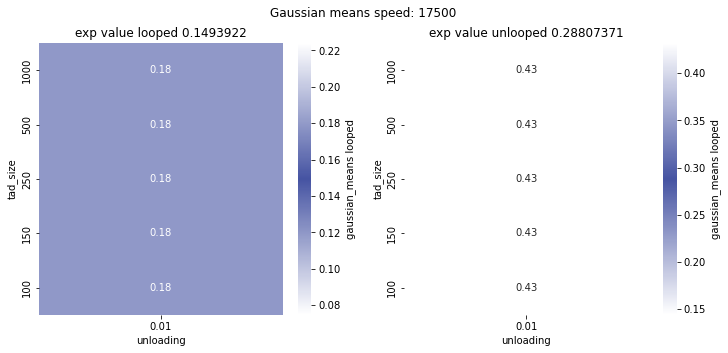

In [13]:
pdf = PdfPages(
    f"/tungstenfs/scratch/ggiorget/pavel/code_projects/systematic_chrodyn_simulations/langevin_simulations/analysis_sweep/revision1/diff_tads/{dataset_name}_2states_HMM_neighbor_{nneighbor}.pdf"
)

speed = "17500"
exp_looped = 0.1493922
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [(1, 1, 1), (69 / 255, 83 / 255, 162 / 255), (1, 1, 1)]
)
norm = mcolors.TwoSlopeNorm(
    vmin=exp_looped * 0.5, vcenter=exp_looped, vmax=exp_looped * 1.5
)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
gaussian_means = gaussian_means.astype({"tad_size": "int32"})
sns.heatmap(
    gaussian_means[(gaussian_means.state == "looped") & (gaussian_means.speed == speed)]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "gaussian_means")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "gaussian_means looped"},
    norm=norm,
    ax=ax[0],
)
ax[0].set_title(f"exp value looped {exp_looped}")

exp_unlooped = 0.28807371
norm = mcolors.TwoSlopeNorm(
    vmin=exp_unlooped * 0.5, vcenter=exp_unlooped, vmax=exp_unlooped * 1.5
)

sns.heatmap(
    gaussian_means[
        (gaussian_means.state == "unlooped") & (gaussian_means.speed == speed)
    ]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "gaussian_means")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "gaussian_means looped"},
    norm=norm,
    ax=ax[1],
)
ax[1].set_title(f"exp value unlooped {exp_unlooped}")
plt.suptitle(f"Gaussian means speed: {speed}")
plt.show()
#pdf.savefig(fig)

### Plot average proximal state duration

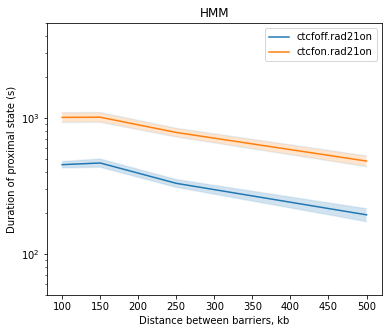

In [14]:
# ctcf_off = 270
speed = "17500"
ctcf_off = 378.529412
ctcf_on = 981.293706
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off * 0, vcenter=ctcf_off, vmax=ctcf_off * 2)
mean = mean.astype({"tad_size": "int32"})

fig, ax = plt.subplots(figsize=(6, 5))
for ctcf, sdf in (
    mean[(mean.speed == speed)]
    .reset_index()
    .replace({"tad_size": conversion_beads_to_kb_int})
    .sort_values(by=["tad_size"], ascending=False)
    .groupby("ctcf")
):
    x = sdf.tad_size.values
    y = sdf.contact_duration.values
    yerr = sdf.contact_duration_sem.values
    lower, upper = y - yerr, y + yerr
    ax.plot(x, y, label=f"{ctcf}")
    ax.plot(x, lower, color="tab:blue", alpha=0.1)
    ax.plot(x, upper, color="tab:blue", alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2)
    ax.set(
        yscale="log",
        title="HMM",
        xlabel="Distance between barriers, kb",
        ylabel="Duration of proximal state (s)",
        ylim=(50, 5000),
    )
plt.legend()
plt.show()
pdf.savefig(fig)

### Plot average first passage time

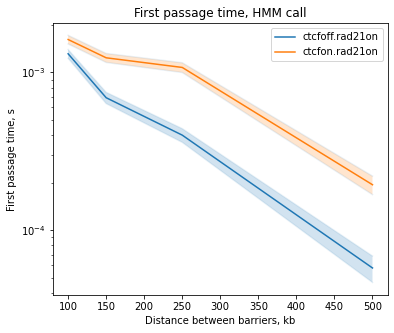

In [15]:
mean.loc[mean["second_passage_time"] > 45000, "second_passage_time"] = np.nan #filter when entire track without contacts

# ctcf_off = 420
speed = "17500"
ctcf_off = 798.361204
ctcf_on = 294.606742
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off * 0, vcenter=ctcf_off, vmax=ctcf_off * 2)
mean = mean.astype({"tad_size": "int32"})

fig, ax = plt.subplots(figsize=(6, 5))
for ctcf, sdf in (
    mean[(mean.speed == speed)]
    .reset_index()
    .replace({"tad_size": conversion_beads_to_kb_int})
    .sort_values(by=["tad_size"], ascending=False)
    .groupby("ctcf")
):
    x = sdf.tad_size.values
    y = sdf.second_passage_time.values
    yerr_b = sdf.second_passage_time_sem.values
    yerr = yerr_b/y**2
    lower, upper = 1/y - yerr, 1/y + yerr
    ax.plot(x, 1/y, label=f"{ctcf}")
    ax.plot(x, lower, color="tab:blue", alpha=0.1)
    ax.plot(x, upper, color="tab:blue", alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2)
    ax.set(
        yscale="log",
        title="First passage time, HMM call",
        xlabel="Distance between barriers, kb",
        ylabel="First passage time, s",
    )
plt.legend()
plt.show()
pdf.savefig(fig)

### Plot average contact duration

In [16]:
nneighbors = 3
tads = [12, 123, 18, 29, 61]
total_streaks_loop = {}
total_streaks_unloop = {}

for i in range(5):
    for ctcf, df in all_tad_sizes_dataset_orig[i].groupby("ctcf"):
        cols2sum = [
            x for x in df.columns[1:-7].values if abs(eval(x) + tads[i]) < nneighbors
        ]
        df["contact"] = df[cols2sum].sum(axis=1)
        df.loc[df["contact"] > 0, "contact"] = 1
        vals, _, lens = find_runs(df["contact"].values)
        total_streaks_loop[str(tads[i]) + ctcf] = lens[vals == 1]
        total_streaks_unloop[str(tads[i]) + ctcf] = lens[vals == 0]

In [17]:
gt_data_2_plot_loop = np.zeros((2, 5, 4))
for i, ctcf in enumerate(["on", "off"]):
    for j, tad in enumerate(sorted(tads)):
        gt_data_2_plot_loop[i, j, 0] = tad
        try:
            gt_data_2_plot_loop[i, j, 1] = np.nanmean(total_streaks_loop[str(tad) + ctcf])
        except:
            gt_data_2_plot_loop[i, j, 1] = np.nan
        try:
            gt_data_2_plot_loop[i, j, 2] = np.nanstd(total_streaks_loop[str(tad) + ctcf])
        except:
            gt_data_2_plot_loop[i, j, 2] = np.nan
        try:
            gt_data_2_plot_loop[i, j, 3] = np.nanstd(
                total_streaks_loop[str(tad) + ctcf]
            ) / np.sqrt(len(total_streaks_loop[str(tad) + ctcf]))
        except:
            gt_data_2_plot_loop[i, j, 3] = np.nan

/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
gt_data_2_plot_unloop = np.zeros((2, 5, 4))
for i, ctcf in enumerate(["on", "off"]):
    for j, tad in enumerate(sorted(tads)):
        gt_data_2_plot_unloop[i, j, 0] = tad
        try:
            gt_data_2_plot_unloop[i, j, 1] = np.nanmean(
                total_streaks_unloop[str(tad) + ctcf]
            )
        except:
            gt_data_2_plot_unloop[i, j, 1] = np.nan
        try:
            gt_data_2_plot_unloop[i, j, 2] = np.nanstd(
                total_streaks_unloop[str(tad) + ctcf]
            )
        except:
            gt_data_2_plot_unloop[i, j, 2] = np.nan
        try:
            gt_data_2_plot_unloop[i, j, 3] = np.nanstd(
                total_streaks_unloop[str(tad) + ctcf]
            ) / np.sqrt(len(total_streaks_unloop[str(tad) + ctcf]))
        except:
            gt_data_2_plot_unloop[i, j, 3] = np.nan

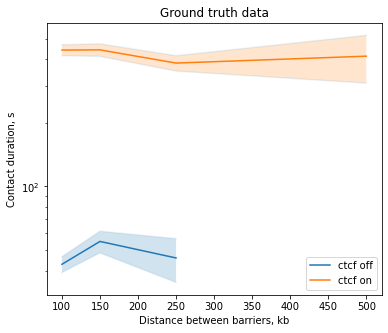

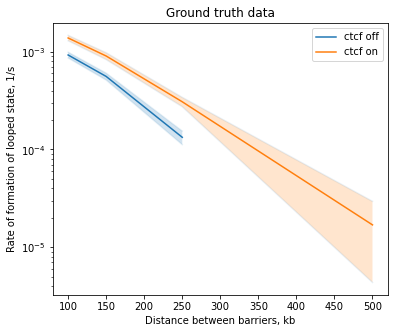

In [19]:
x = np.array([100, 150, 250, 500, 1000])
gt_data_2_plot_unloop[0, :, 1][gt_data_2_plot_unloop[0, :, 1] > 460000] = np.nan
gt_data_2_plot_unloop[1, :, 1][gt_data_2_plot_unloop[1, :, 1] > 460000] = np.nan
fig, ax = plt.subplots(figsize=(6, 5))
ax.set(
    title="Ground truth data",
    xlabel="Distance between barriers, kb",
    ylabel="Contact duration, s",
    yscale="log",
)
y = gt_data_2_plot_loop[1, :, 1]
yerr = gt_data_2_plot_loop[1, :, 3]
lower, upper = y - yerr, y + yerr
ax.plot(x, y, label=f"ctcf off")
ax.plot(x, lower, color="tab:blue", alpha=0.1)
ax.plot(x, upper, color="tab:blue", alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)

y = gt_data_2_plot_loop[0, :, 1]
yerr = gt_data_2_plot_loop[0, :, 3]
lower, upper = y - yerr, y + yerr
ax.plot(x, y, label=f"ctcf on")
ax.plot(x, lower, color="tab:blue", alpha=0.1)
ax.plot(x, upper, color="tab:blue", alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
plt.legend()
plt.show()
pdf.savefig(fig)


fig, ax = plt.subplots(figsize=(6, 5))
ax.set(
    title="Ground truth data",
    xlabel="Distance between barriers, kb",
    ylabel="Rate of formation of looped state, 1/s",
    yscale="log",
)
y = gt_data_2_plot_unloop[1, :, 1]
yerr_b = gt_data_2_plot_unloop[1, :, 3]
yerr = yerr_b/y**2
lower, upper = 1/y - yerr, 1/y + yerr
ax.plot(x, 1/y, label=f"ctcf off")
ax.plot(x, lower, color="tab:blue", alpha=0.1)
ax.plot(x, upper, color="tab:blue", alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)

y = gt_data_2_plot_unloop[0, :, 1]
yerr_b = gt_data_2_plot_unloop[0, :, 3]
yerr = yerr_b/y**2
lower, upper = 1/y - yerr, 1/y + yerr
ax.plot(x, 1 / y, label=f"ctcf on")
ax.plot(x, lower, color="tab:blue", alpha=0.1)
ax.plot(x, upper, color="tab:blue", alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)

plt.legend()
plt.show()
pdf.savefig(fig)
pdf.close()